In [1]:
import re
import nltk
import time
import numpy as np
import pandas as pd
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import gensim.parsing.preprocessing as gpp
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import gensim
# print(gensim.parsing.preprocessing.STOPWORDS)

### Custom function for data cleaning

In [2]:
def data_cleaning(tweets_struct):
    # Removing links and ampersand attached text from the tweets
    text_list = [re.sub(r"(?:\@|\&|http)\S+", "", item) for item in tweets_struct["Text"]]

    text_list = [gpp.strip_numeric(item) for item in text_list]
    text_list = [gpp.strip_non_alphanum(item) for item in text_list]
    text_list = [gpp.strip_punctuation(item) for item in text_list]
    text_list = [gpp.strip_short(item, minsize=2) for item in text_list]
    text_list = [item.lower() for item in text_list]
    text_list = [gpp.remove_stopwords(item) for item in text_list]

    # Remove everything except text and numbers
    # text_list["text"] = [re.sub(r"[^a-zA-Z0-9]+", ' ', item) for item in text_list["text"]]
    
    return text_list

In [3]:
def frequency_of_words(tweets_df):
    c = tweets_tokenized.apply(pd.value_counts).sum(axis=1, skipna=True).sort_values(ascending=False)
    words = tweets_tokenized.apply(pd.value_counts).sum(axis=1, skipna=True).sum()
    c = c[:10,]
    
    plt.figure(figsize=(10,5))
    plt.title('Frequency of words in tweets')
    plt.ylabel('Frequency')
    plt.xlabel('Words')
    ax = sns.barplot(c.index, c.values, alpha=0.8)
    
    for p in ax.patches:
        ax.annotate("{:.2f}%".format((p.get_height()/words)*100),
                    (p.get_x()+p.get_width()/2.,p.get_height()),
                     ha='center', va='center', fontsize=11, color='gray', xytext=(0, 20),
                     textcoords='offset points')

In [4]:
# Function to count total token words in a DataFrame or a column
def count_words(var):
    if isinstance(var, pd.Series):
        tokens = 0
        for items in var.iteritems():
            tokens += len(items[1].split())
        return tokens
    elif isinstance(var, pd.DataFrame):
        return var.count().sum()
    
# Map POS tag to first character lemmatize() accepts
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Custom functionfor text lemmatization and removing non-dictionary words
def lemmatize_custom(my_list, c_words):
    start = time.time()
    lemma = nltk.wordnet.WordNetLemmatizer()
    # words = set(nltk.corpus.words.words())

    # c_words = [lemma.lemmatize(x, get_wordnet_pos(x)) for x in c_words]
    # for i in c_words:
    #    words.add(i)
        
    tweets_ll = []
    for item in my_list:
        word_list = item.split()
        word_list = [x for x in word_list if x in c_words]
        word_list = [lemma.lemmatize(x, get_wordnet_pos(x)) for x in word_list]
        # word_list = [x for x in word_list if x in words]
        tweets_ll.append(word_list)
        word_list = None
    end = time.time()
    print("Total time taken in lemmatization: {:.2f} seconds".format(end-start))
    return pd.DataFrame(tweets_ll)

## Preprocessing for Part 2

In [5]:
tweets = pd.read_csv("tweets_sentiment.csv", index_col=0)
words_earlier = count_words(tweets["Text"])
print("Number of rows: {}".format(tweets.shape[0]))
tweets.head()

Number of rows: 1383


,Text,Date,Retweets,Favorites,Mentions,HashTags
0,Things realized during Lockdown: 1. Cooking is...,2020-04-01 05:10:32+00:00,0,0,NaN,NaN
1,"I received two messages today, one from @swigg...",2020-04-01 05:13:18+00:00,0,6,@swiggy_in @NetMeds,NaN
2,Whats wrong with zomato i am unable to order a...,2020-04-01 05:19:26+00:00,0,0,@zomatocare @Zomato @ZomatoIN @iamsrk,#Lockdown21 #lockdownindia
3,@MumbaiPolice @ThaneCityPolice It’s not milita...,2020-04-01 09:22:14+00:00,0,0,@MumbaiPolice @ThaneCityPolice @Zomato,NaN
4,#AskZee sir I am a zomato delivery boy. due lo...,2020-04-01 09:23:03+00:00,0,0,NaN,#AskZee


In [6]:
tweets_text = data_cleaning(tweets)
pd.DataFrame(tweets_text, columns=["Text"]).head()

,Text
0,things realized lockdown cooking life skill le...
1,received messages today stating deliver food f...
2,whats wrong zomato unable order lockdown suspi...
3,military rule lockdown steal beverages deliver...
4,askzee sir zomato delivery boy lockdown earnin...


In [7]:
# custom_words are compulsory words not to be removed in lemmatization
custom_words = []

with open("sentiment_words.txt","r") as f:
    lines = [line.strip() for line in f]
for i in lines:
    custom_words.append(i)

print(custom_words[:10])
print("\nRunning lemmatization ...\n")
tweets_tokenized = lemmatize_custom(tweets_text, custom_words)
print("Number of rows: {}".format(tweets_tokenized.shape[0]))
tweets_tokenized.head(5)

['nervous', 'confusion', 'safe', 'accessible', 'ease', 'crappy', 'late', 'bad', 'disadvantage', 'exorbitantly']

Running lemmatization ...

Total time taken in lemmatization: 4.22 seconds
Number of rows: 1383


,0,1,2,3,4
0,swiggy,None,None,None,None
1,fast,None,None,None,None
2,zomato,suspicious,zomato,None,None
3,None,None,None,None,None
4,zomato,None,None,None,None


In [8]:
words_after = count_words(tweets_tokenized)
print("Words before preprocessing: {}".format(words_earlier))
print("Words after preprocessing: {}".format(words_after))
print("Words removed: {}".format(words_earlier-words_after))

# Removing duplicate word from rows
df1 = tweets_tokenized.stack().reset_index().drop(columns='level_1').drop_duplicates()
df1['col'] = df1.groupby('level_0').cumcount()
tweets_tokenized = (df1.pivot(index='level_0', columns='col', values=0)
          .rename_axis(index=None, columns=None))

tweets_tokenized.dropna(axis = 0,how = 'all',inplace = True, thresh=2)

print("Number of rows: {}".format(tweets_tokenized.shape[0]))
tweets_tokenized.head(5)

Words before preprocessing: 51070
Words after preprocessing: 2097
Words removed: 48973
Number of rows: 574


,0,1,2,3
2,zomato,suspicious,NaN,NaN
5,bad,swiggy,zomato,NaN
9,swiggy,good,NaN,NaN
11,zomato,safe,NaN,NaN
15,swiggy,great,NaN,NaN


In [9]:
# Remove multiple products/services from single rows
products = ["zomato","swiggy"]
new_list = []

for item in tweets_tokenized.itertuples(index=False):
    mult = 0
    for i in list(item):
        if i in products:
            mult += 1

    if mult <= 1:
        new_list.append(list(item))
    else:
        pass

tweets_tokenized = pd.DataFrame(new_list)
tweets_tokenized.index += 1
tweets_tokenized.to_csv("tweets_tokenized_sentiments.csv",header=False,index=False)
tweets_tokenized.head()

,0,1,2,3
1,zomato,suspicious,NaN,NaN
2,swiggy,good,NaN,NaN
3,zomato,safe,NaN,NaN
4,swiggy,great,NaN,NaN
5,confuse,zomato,NaN,NaN


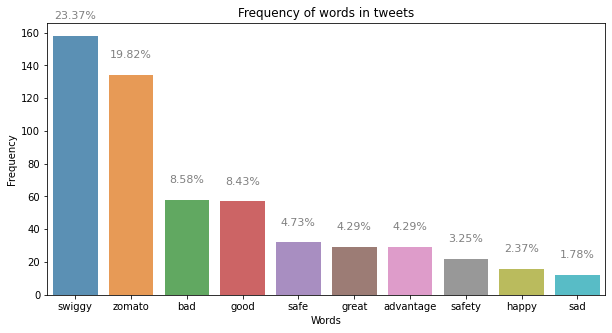

In [10]:
frequency_of_words(tweets_tokenized)

In [11]:
# Convert dataframe to list 
tweets_list = tweets_tokenized.T.apply(lambda x: x.dropna().tolist()).tolist()

# One Hot Encoding
te = TransactionEncoder()
te_ary = te.fit(tweets_list).transform(tweets_list)
tweets_ohe = pd.DataFrame(te_ary, columns = te.columns_)
tweets_ohe.head(5)

,advantage,afraid,angry,appeal,arrogant,awful,bad,bore,boring,brave,...,seriousness,shock,silly,strength,stupid,stupidest,suspicious,swiggy,wonderful,zomato
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [12]:
freq_items = apriori(tweets_ohe, min_support=0.01, use_colnames=True, verbose=0)
freq_items.sort_values(by = "support", ascending = False)

,support,itemsets
19,0.484663,(swiggy)
21,0.411043,(zomato)
1,0.177914,(bad)
9,0.174847,(good)
25,0.098160,"(zomato, bad)"
16,0.098160,(safe)
29,0.092025,"(swiggy, good)"
10,0.088957,(great)
0,0.088957,(advantage)
17,0.067485,(safety)


In [16]:
rules = association_rules(freq_items, metric="lift", min_threshold=1)
rules.sort_values(by = ["lift","confidence","support"], ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5,(easy),(swiggy),0.018405,0.484663,0.018405,1.000000,2.063291,0.009485,inf
11,(happiness),(swiggy),0.018405,0.484663,0.018405,1.000000,2.063291,0.009485,inf
4,(swiggy),(easy),0.484663,0.018405,0.018405,0.037975,2.063291,0.009485,1.020342
10,(swiggy),(happiness),0.484663,0.018405,0.018405,0.037975,2.063291,0.009485,1.020342
17,(safe),(zomato),0.098160,0.411043,0.061350,0.625000,1.520522,0.021002,1.570552
16,(zomato),(safe),0.411043,0.098160,0.061350,0.149254,1.520522,0.021002,1.060058
3,(bad),(zomato),0.177914,0.411043,0.098160,0.551724,1.342254,0.025029,1.313827
2,(zomato),(bad),0.411043,0.177914,0.098160,0.238806,1.342254,0.025029,1.079995
7,(great),(good),0.088957,0.174847,0.018405,0.206897,1.183303,0.002851,1.040411
6,(good),(great),0.174847,0.088957,0.018405,0.105263,1.183303,0.002851,1.018224
